## This notebook check the hexapod state transitions and move/offset commands
## It also checks the LUT against the input polynomials, before and after a slew

This notebook works with both hexapods.

Prerequisits:

The MTMount and the MTRotator must send telemetry for mount azimuth and elevation and rotation angle.

In [1]:
from lsst.ts import salobj
import asyncio
import os
import yaml

import numpy as np
from matplotlib import pyplot as plt
from astropy.time import Time
from datetime import datetime, timedelta
import pandas as pd

from lsst.ts.idl.enums import MTPtg

from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
import astropy.units as u

from lsst_efd_client import EfdClient

To switch between the hexapods, change the cell below.

In [2]:
hexIdx = 1 #camera hexapod
#hexIdx = 2 #M2 hexapod

In [3]:
import os
print(os.environ["OSPL_URI"])
if os.environ.get("LSST_DDS_ALIGNER", "false") != "false":
    print("LSST_DDS_ALIGNER is mis-configured")

file:///home/hdrass/WORK/ts_ddsconfig/config/ospl-shmem.xml


In [4]:
start_time = datetime.now()
script = salobj.Controller("Script", index=42658887)

#wait 10 second may help with DDS problems; closing all other kernels may help too
#This is to avoid a race condition between when the domain register the master and the readers are registered.
#await asyncio.sleep(25) 

In [5]:
#Only needed wht doing a test with the telescope slewing
#ptg = salobj.Remote(script.domain, "MTPtg")

In [6]:
mthex = salobj.Remote(script.domain, "MTHexapod", index=hexIdx) #1 for camera hexapod and 2 for m2 hexapod

electrical DDS read queue is full (100 elements); data may be lost
application DDS read queue is full (100 elements); data may be lost
actuators DDS read queue is full (100 elements); data may be lost
electrical DDS read queue is filling: 37 of 100 elements
electrical DDS read queue is filling: 14 of 100 elements


In [7]:
mtptg = salobj.Remote(script.domain, "MTPtg")

In [8]:
mtm = salobj.Remote(script.domain, "MTMount")

In [9]:
#Start a controller instead of the Mount simulator
#mount = salobj.Controller(name="MTMount", index=0)

In [10]:
mtrot = salobj.Remote(script.domain, "MTRotator")
print(f'time to start is {datetime.now() - start_time} [s]')

timeAndDate DDS read queue is filling: 14 of 100 elements


time to start is 0:00:18.566227 [s]


In [11]:
await asyncio.gather(mtm.start_task,
                     script.start_task,                      
                     mtrot.start_task,
                     mthex.start_task,
                     mtptg.start_task)

rotation DDS read queue is full (100 elements); data may be lost


[None, None, None, None, None]

motors DDS read queue is full (100 elements); data may be lost
electrical DDS read queue is full (100 elements); data may be lost


In [12]:
#This only works on domain 0
#await ptg.start_task

rotation DDS read queue is filling: 18 of 100 elements
rotation DDS read queue is filling: 18 of 100 elements


## Check the heartbeats

In [13]:
#As long as you get something its OK. we dont' care about heartbeat
await mthex.evt_heartbeat.next(flush=True, timeout=5)

In [14]:
#This only works on domain 0
await mtptg.evt_heartbeat.next(flush=True, timeout=5)

In [15]:
await mtrot.evt_heartbeat.next(flush=True, timeout=5)

In [16]:
await mtm.evt_heartbeat.next(flush=True, timeout=5)

### Test the hexapod state transitions. If the hexapod is already enabled, disable then enable it.

In [17]:
state = await mthex.evt_summaryState.aget(timeout=5)
print('staring with: hex state', salobj.State(state.summaryState), pd.to_datetime(state.private_sndStamp, unit='s'))
if state.summaryState == 2:
    await salobj.set_summary_state(mthex, salobj.State.DISABLED) #disable hex

staring with: hex state State.ENABLED 2021-07-05 21:59:51.061982720


In [18]:
await salobj.set_summary_state(remote=mthex, state=salobj.State.STANDBY)


[<State.DISABLED: 1>, <State.STANDBY: 5>]

In [19]:
await salobj.set_summary_state(remote=mthex, state=salobj.State.DISABLED)

[<State.STANDBY: 5>, <State.DISABLED: 1>]

In [20]:
await salobj.set_summary_state(mthex, salobj.State.ENABLED, settingsToApply="default") #enable hex

[<State.DISABLED: 1>, <State.ENABLED: 2>]

## Check that the other components are enabled or, if not, enable them 

In [22]:
await salobj.set_summary_state(mtm, salobj.State.ENABLED)

[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

In [23]:
await salobj.set_summary_state(mtrot, salobj.State.ENABLED)

RuntimeError: Error on cmd=cmd_start, initial_state=5: msg='Command failed', ackcmd=(ackcmd private_seqNum=1784759104, ack=<SalRetCode.CMD_FAILED: -302>, error=1, result='Failed: Controller has CSC commands disabled; use the EUI to enable CSC commands')

In [70]:
await salobj.set_summary_state(mtptg, salobj.State.ENABLED)

[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

## Check that the configurations and that the needed telemetry is comming in:

In [39]:
#Check some configurations for the hexapod
hexConfig = await mthex.evt_configuration.aget(timeout=10.)
print("pivot at (%.0f, %.0f, %.0f) microns "%(hexConfig.pivotX, hexConfig.pivotY, hexConfig.pivotZ))
print("maxXY = ", hexConfig.maxXY, "microns, maxZ= ", hexConfig.maxZ, " microns")
print("maxUV = ", hexConfig.maxUV, "deg, maxW= ", hexConfig.maxW, " deg")

pivot at (0, 0, -2758400) microns 
maxXY =  11400.0 microns, maxZ=  13100.0  microns
maxUV =  0.36 deg, maxW=  0.1  deg


In [46]:
end = Time(datetime.now())
start = end - timedelta(hours=3)
#logeventTarget = await client.select_time_series('lsst.sal.MTMount.logevent_target', '*', start.tai, end.tai)
#With this we can get the elevation when a controller is running
MTMountElevation = await client.select_time_series('lsst.sal.MTMount.elevation', '*', start.tai, end.tai)
MTMountAzimuth = await client.select_time_series('lsst.sal.MTMount.azimuth', '*', start.tai, end.tai)
MTRotPosition = await client.select_time_series('lsst.sal.MTRotator.rotation', '*', start.tai, end.tai)

application DDS read queue is filling: 18 of 100 elements
rotation DDS read queue is filling: 17 of 100 elements
electrical DDS read queue is filling: 20 of 100 elements
motors DDS read queue is filling: 20 of 100 elements
actuators DDS read queue is filling: 24 of 100 elements
electrical DDS read queue is filling: 24 of 100 elements
ccwFollowingError DDS read queue is filling: 24 of 100 elements


In [41]:
#get the elevation into a variable
mtmElev=MTMountElevation.actualPosition
print("Mount elevation from the EFD:")
mtmElev

Mount controller elevation from the EFD:


2021-07-05 22:09:06.692000+00:00    80
2021-07-05 22:09:06.894000+00:00    80
2021-07-05 22:09:07.095000+00:00    80
2021-07-05 22:09:07.296000+00:00    80
2021-07-05 22:09:07.498000+00:00    80
                                    ..
2021-07-05 22:14:12.807000+00:00    80
2021-07-05 22:14:13.009000+00:00    80
2021-07-05 22:14:13.210000+00:00    80
2021-07-05 22:14:13.412000+00:00    80
2021-07-05 22:14:13.613000+00:00    80
Name: actualPosition, Length: 1525, dtype: int64

In [42]:
mtmAzimuth = MTMountAzimuth.actualPosition
print("Mount azimuth from the EFD:")
mtmAzimuth

Mount controller azimuth from the EFD:


2021-07-05 22:09:06.691000+00:00    0
2021-07-05 22:09:06.893000+00:00    0
2021-07-05 22:09:07.094000+00:00    0
2021-07-05 22:09:07.295000+00:00    0
2021-07-05 22:09:07.497000+00:00    0
                                   ..
2021-07-05 22:14:12.806000+00:00    0
2021-07-05 22:14:13.008000+00:00    0
2021-07-05 22:14:13.209000+00:00    0
2021-07-05 22:14:13.411000+00:00    0
2021-07-05 22:14:13.612000+00:00    0
Name: actualPosition, Length: 1525, dtype: int64

In [47]:
mtrotPosition = MTRotPosition.actualPosition
print("MTRotator positon from the EFD:")
mtrotPosition

MTRotator positon from the EFD:


2021-07-05 19:19:43.561000+00:00    30.000348
2021-07-05 19:19:43.611000+00:00    30.000347
2021-07-05 19:19:43.661000+00:00    30.000346
2021-07-05 19:19:43.711000+00:00    30.000347
2021-07-05 19:19:43.761000+00:00    30.000347
                                      ...    
2021-07-05 22:19:43.333000+00:00    -0.001394
2021-07-05 22:19:43.383000+00:00    -0.001395
2021-07-05 22:19:43.433000+00:00    -0.001395
2021-07-05 22:19:43.483000+00:00    -0.001395
2021-07-05 22:19:43.533000+00:00    -0.001395
Name: actualPosition, Length: 97227, dtype: float64

## Start the EFD client

In [24]:
client = EfdClient('summit_efd')

In [25]:
# the next line only work if information were sent to the EFD during the time spann "timedelta"!
csc_index = 1
end = Time(datetime.now(), scale='tai')
start = end - timedelta(hours=6)
while True: #may need to wait a few seconds before event shows up in EFD
    dfe = await client.select_time_series('lsst.sal.MTHexapod.logevent_summaryState', '*', start, end, csc_index)
    #dfe = await client.select_time_series('lsst.sal.MTMount.elevation', '*', start, end)
    if len(dfe)>0:
        break
#to check messages in Kafka, go to https://lsst-kafka-0-nts-efd.ncsa.illinois.edu/
#we cannot get time series data from DDS. We have to query the EFD

In [26]:
dfe

,MTHexapodID,priority,private_efdStamp,private_host,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp,summaryState
2021-07-05 18:54:02.062000+00:00,1,0,1.625511e+09,0,MTHexapod:1,1.625511e+09,7886,1.625511e+09,959a0a03,73,1.625511e+09,3
2021-07-05 21:08:41.175000+00:00,1,0,1.625519e+09,0,MTHexapod:1,1.625519e+09,7886,1.625519e+09,959a0a03,74,1.625519e+09,4
2021-07-05 21:08:55.299000+00:00,1,0,1.625519e+09,0,MTHexapod:1,1.625519e+09,7886,1.625519e+09,959a0a03,75,1.625519e+09,5
2021-07-05 21:08:58.313000+00:00,1,0,1.625519e+09,0,MTHexapod:1,1.625519e+09,7886,1.625519e+09,959a0a03,76,1.625519e+09,1
2021-07-05 21:09:03.088000+00:00,1,0,1.625519e+09,0,MTHexapod:1,1.625519e+09,7886,1.625519e+09,959a0a03,77,1.625519e+09,2
2021-07-05 21:09:54.339000+00:00,1,0,1.625519e+09,0,MTHexapod:1,1.625519e+09,7886,1.625519e+09,959a0a03,78,1.625519e+09,1
2021-07-05 21:10:03.108000+00:00,1,0,1.625519e+09,0,MTHexapod:1,1.625519e+09,7886,1.625519e+09,959a0a03,79,1.625519e+09,5
2021-07-05 21:10:22.327000+00:00,1,0,1.625519e+09,0,MTHexapod:1,1.625519e+09,7886,1.625519e+09,959a0a03,80,1.625519e+09,1
2021-07-05 21:10:27.813000+00:00,1,0,1.625519e+09,0,MTHexapod:1,1.625519e+09,7886,1.625519e+09,959a0a03,81,1.625519e+09,5
2021-07-05 21:10:32.498000+00:00,1,0,1.625519e+09,0,MTHexapod:1,1.625519e+09,7886,1.625519e+09,959a0a03,82,1.625519e+09,1


# Check the move behavior when LUT is disabled.

In [82]:
lutMode = await mthex.evt_compensationMode.aget(timeout=10)
print("compsensation mode enabled?",lutMode.enabled)

compsensation mode enabled? True


In [83]:
async def printPosition(hex):
    pos = await mthex.tel_application.next(flush=True, timeout=10.)
    print("Current Hexapod position")
    print(" ".join(f"{p:10.2f}" for p in pos.position))
await printPosition(hex)

Current Hexapod position
     -0.25      -0.58      -0.18      -0.00       0.00      -0.00


In [84]:
test_message = "Camera Hexapod Integration Test"

In [85]:
#This command is to set the Hexapod to zero position
now = datetime.now()
script.log.info(f"START- {test_message} -- LVV-T1600 -- Move to Zero- Starting time: {now} UTC")
await mthex.cmd_move.set_start(x=0,y=0,z=0, u=0,v=0,w=0,sync=True)

INFO:Script:START- Camera Hexapod Integration Test -- LVV-T1600 -- Move to Zero- Starting time: 2021-07-05 22:36:08.344298 UTC


In [31]:
#To stop the Hexapod
await mthex.cmd_stop.set_start()

If you want to observe the motions in chronograf, consider using "AND MTHexapodID={hexId}" to filter out telemetry from the other hexapod

In [34]:
now = datetime.now()
script.log.info(f"START- {test_message} -- LVV-T1600 Compensation mode test Step 17- Starting time: {now} UTC")
mthex.evt_inPosition.flush()
for step in range(5,-1,-1):
    await mthex.cmd_move.set_start(x=0,y=0,z=100*step, u=0,v=0,w=0,sync=True)
    while True:
        state = await mthex.evt_inPosition.next(flush=False, timeout=10)
        print("hex in position?",state.inPosition, pd.to_datetime(state.private_sndStamp, unit='s'))
        if state.inPosition:
            break    

hex in position? False 2021-07-05 22:11:41.156809984
hex in position? True 2021-07-05 22:11:43.679096576
hex in position? False 2021-07-05 22:11:43.859335424
hex in position? True 2021-07-05 22:11:45.300885504
hex in position? False 2021-07-05 22:11:45.481185024
hex in position? True 2021-07-05 22:11:46.962600704
hex in position? False 2021-07-05 22:11:47.102935552
hex in position? True 2021-07-05 22:11:48.633995520
hex in position? False 2021-07-05 22:11:48.814097152
hex in position? True 2021-07-05 22:11:50.296137216
hex in position? False 2021-07-05 22:11:50.477005568
hex in position? True 2021-07-05 22:11:51.957536768


In [48]:
await printPosition(hex)

Current Hexapod position
     -0.32      -0.51      -0.19      -0.00       0.00      -0.00


In [79]:
mthex.evt_inPosition.flush()
for step in [1,2,3,-3,-2,-1]:
    #according to XML, units are micron and degree
    await mthex.cmd_offset.set_start(x=0,y=0,z=100*step, u=0,v=0,w=0,sync=True)
    while True:
        state = await mthex.evt_inPosition.next(flush=False, timeout=10)
        print("hex in position?",state.inPosition, pd.to_datetime(state.private_sndStamp, unit='s'))
        if state.inPosition:
            break
     
    await printPosition(mthex)
    
    end = Time(datetime.now(), scale='tai')

hex in position? False 2021-07-05 22:35:40.975931648
hex in position? True 2021-07-05 22:35:42.466839808
Current Hexapod position
      0.27       0.36     100.37       0.00      -0.00       0.00
hex in position? False 2021-07-05 22:35:42.686994432
hex in position? True 2021-07-05 22:35:44.538967552
Current Hexapod position
      0.19      -0.08     300.32       0.00      -0.00       0.00
hex in position? False 2021-07-05 22:35:44.719019264
hex in position? True 2021-07-05 22:35:46.831439872
Current Hexapod position
      0.38      -0.57     600.31      -0.00      -0.00      -0.00
hex in position? False 2021-07-05 22:35:47.011743232
hex in position? True 2021-07-05 22:35:49.123595776
Current Hexapod position
     -0.75      -0.54     299.77      -0.00       0.00      -0.00
hex in position? False 2021-07-05 22:35:49.393869568
hex in position? True 2021-07-05 22:35:51.196079616
Current Hexapod position
     -0.23      -0.64      99.72      -0.00       0.00      -0.00
hex in position? Fal

In [80]:
start = end - timedelta(seconds=120)
df = await client.select_time_series('lsst.sal.MTHexapod.application', '*', start, end, csc_index)
idx=df.MTHexapodID==1
df = df[idx]

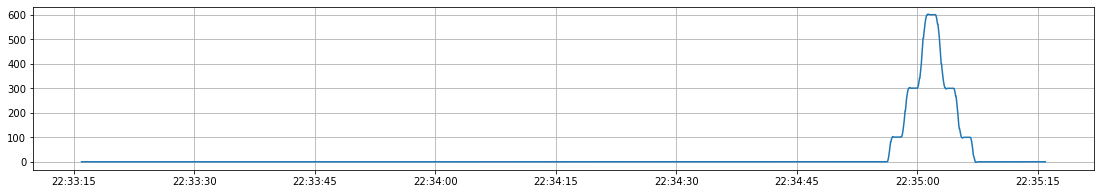

In [81]:
fig, ax = plt.subplots(figsize=(19,3))
plt.plot(df.position2)
plt.grid()

### When the LUT is enabled

In [57]:
await mthex.cmd_setCompensationMode.set_start(enable=1, timeout=10)
lutMode = await mthex.evt_compensationMode.aget(timeout=10)
print("compsensation mode enabled?",lutMode.enabled)

compsensation mode enabled? True


In [56]:
#Switch compensation mode off:
await mthex.cmd_setCompensationMode.set_start(enable=0, timeout=10)
lutMode = await mthex.evt_compensationMode.aget(timeout=10)
print("compsensation mode enabled?",lutMode.enabled)

compsensation mode enabled? False


In [53]:
await printPosition(hex)

Current Hexapod position
     -0.31      -0.51      -0.19      -0.00       0.00      -0.00


In [89]:
async def printUncompensatedAndCompensated(hex):
    posU = mthex.evt_uncompensatedPosition.get()
    print('Uncompensated position')
    print(" ".join(f"{p:10.2f}" for p in [getattr(posU, i) for i in 'xyzuvw']))
    print(pd.to_datetime(posU.private_sndStamp, unit='s'))
    posC = mthex.evt_compensatedPosition.get()
    print('Compensated position')
    print(" ".join(f"{p:10.2f}" for p in [getattr(posC, i) for i in 'xyzuvw']))
    print(pd.to_datetime(posC.private_sndStamp, unit='s'))

await printUncompensatedAndCompensated(hex)

Uncompensated position
      0.00       0.00       0.00       0.00       0.00       0.00
2021-07-05 22:35:51.242197504
Compensated position
      0.00       0.00       0.00       0.00       0.00       0.00
2021-07-05 22:35:51.242395904


The inputs to the LUT are currently -
* elevation (from mount telemetry) 
* temperature (mount truss? not implemented yet)
* azimuth (not implemented)
* rotator angle (not implemented)

In [ ]:
#Mount needs to be prepared
#await salobj.set_summary_state(mount, salobj.State.ENABLED)

In [ ]:
#Only works when mount or mount simulator are active. Best on domain 1
#mountAngle = await mount.tel_elevation.aget(timeout=10.)
#print("mount elevation angle", mountAngle.angleActual)
#elev = mountAngle.angleActual

In [ ]:
#To set the elevation for a controller
#mount.evt_target.set_put(elevation=45)

In [62]:
elevationFixed=80.0

In [60]:
LUTfile = '%s/notebooks/ts_config_mttcs/MTHexapod/v1/default.yaml'%(os.environ["HOME"])
with open(LUTfile, 'r') as stream:
    aa = yaml.safe_load(stream)
if mthex.salinfo.index == 1:
    elevCoeff = aa['camera_config']['elevation_coeffs']
    tCoeff = aa['camera_config']['temperature_coeffs']
elif mthex.salinfo.index == 2:
    elevCoeff = aa['m2_config']['elevation_coeffs']
    tCoeff = aa['m2_config']['temperature_coeffs']

In [63]:
async def printPredictedComp(elevCoeff, elev):
    '''
    This function deals with the elevation component of the LUT only, for now.
    We will add temperature, azimuth, and rotator angle when they are implemented.
    '''
    pred = []
    print('Predicted LUT compensation:')
    for i in range(6):
        coeff = elevCoeff[i] #starts with C0
        mypoly = np.polynomial.Polynomial(coeff)
        #mypoly = np.poly1d(coeff[::-1]) #if you use poly1d, be aware: it needs C5 first
        pred.append(mypoly(elev))
    print(" ".join(f"{p:10.2f}" for p in pred))
await printPredictedComp(elevCoeff, elevationFixed)
await printUncompensatedAndCompensated(hex)

Predicted LUT compensation:
     -0.87    -423.42     283.37      -0.01       0.00       0.00
Uncompensated position
      0.00       0.00       0.00       0.00       0.00       0.00
2021-07-05 22:12:22.654381312
Compensated position
      0.00       0.00       0.00       0.00       0.00       0.00
2021-07-05 22:12:22.654571520


### Do a slew, then check the LUT again

In [65]:
location = EarthLocation.from_geodetic(lon=-70.747698*u.deg,
                                       lat=-30.244728*u.deg,
                                       height=2663.0*u.m)
print("Current elevation angle = ", elev)

Current elevation angle =  2021-07-05 22:09:06.692000+00:00    80
2021-07-05 22:09:06.894000+00:00    80
2021-07-05 22:09:07.095000+00:00    80
2021-07-05 22:09:07.296000+00:00    80
2021-07-05 22:09:07.498000+00:00    80
                                    ..
2021-07-05 22:14:12.807000+00:00    80
2021-07-05 22:14:13.009000+00:00    80
2021-07-05 22:14:13.210000+00:00    80
2021-07-05 22:14:13.412000+00:00    80
2021-07-05 22:14:13.613000+00:00    80
Name: actualPosition, Length: 1525, dtype: int64


In [66]:
now = datetime.now()
print("Start to point the telescope", now)

alt = 80. * u.deg
az = 0. * u.deg
rot_tel = Angle(0, unit= u.deg) 

Start to point the telescope 2021-07-05 22:28:30.873318


In [67]:
target_name="TMA motion test"
time_data = await mtptg.tel_timeAndDate.next(flush=True, timeout=2)
curr_time_ptg = Time(time_data.mjd, format="mjd", scale="tai")
time_err = curr_time_ptg - Time.now()
print(f"Time error={time_err.sec:0.2f} sec")

print(curr_time_ptg.tai.value)

cmd_elaz = AltAz(alt=alt, az=az, 
                obstime=curr_time_ptg.tai, 
                location=location)
cmd_radec = cmd_elaz.transform_to(ICRS)
# Calculating the other parameters     
rot_pa = rot_tel

Time error=-0.00 sec
59400.93696830643


In [71]:
#The pointing component is commanding the mount directly
ack = await mtptg.cmd_raDecTarget.set_start(
    targetName=target_name,
    frame=MTPtg.CoordFrame.ICRS,
    epoch=2000,  # should be ignored: no parallax or proper motion
    equinox=2000,  # should be ignored for ICRS
    ra=cmd_radec.ra.hour,
    declination=cmd_radec.dec.deg,
    parallax=0,
    pmRA=0,
    pmDec=0,
    rv=0,
    dRA=0,
    dDec=0,
    trackId=9999,
    rotAngle=15.0,
    rotStartFrame=MTPtg.RotFrame.FIXED,
    rotTrackFrame=MTPtg.RotFrame.FIXED,
    rotMode=MTPtg.RotMode.FIELD,
    azWrapStrategy=2,
    timeOnTarget=30,
    timeout=10
)

print(" Now, Waiting 30s")
await asyncio.sleep(30.)
print("System Ready")

 Now, Waiting 30s
System Ready


In [73]:
mountStatus = await mtm.evt_axesInPosition.aget(timeout=5.)
rotStatus = await mtrot.evt_inPosition.aget(timeout=5.)
print('Are we tracking?', mountStatus.elevation , mountStatus.azimuth , rotStatus.inPosition)

Are we tracking? False False False


In [75]:
await mtptg.cmd_stopTracking.set_start(timeout=5.)

AckError: msg='Command failed', ackcmd=(ackcmd private_seqNum=2073467007, ack=<SalRetCode.CMD_FAILED: -302>, error=6612, result='Rejected : command not allowed in current state')

### check angle and LUT after the slew

In [ ]:
mountAngle = await mount.tel_elevation.aget(timeout=10.)
print("mount elevation angle", mountAngle.actualPosition)
elev = mountAngle.actualPosition

In [ ]:
await printPosition(hex)
await printUncompensatedAndCompensated(hex)
await printPredictedComp(elevCoeff, elev)

### Check if the telescope is in tracking mode. If yes, need to stop stacking. 
The alternative is to check "MT Mount status" dash board on Chronograf. Make sure there are three "False".

In [ ]:
mountStatus = await mount.evt_axesInPosition.aget(timeout=5.)
rotStatus = await rot.evt_inPosition.aget(timeout=5.)
trackingStatus = mountStatus.elevation and mountStatus.azimuth and rotStatus.inPosition
print('Are we tracking?', trackingStatus)

In [ ]:
await ptg.cmd_stopTracking.set_start(timeout=5.)

In [ ]:
#Stop the MTMount controller
await mount.close()